In [1]:
from SimPEG import (
    maps,
    utils,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    directives,
    inversion,
)
from SimPEG.electromagnetics.static import resistivity as DC, utils as DCutils
import discretize
import numpy as np
import time
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver

%pylab inline


Populating the interactive namespace from numpy and matplotlib


# Create a mesh

number of cells = 21700


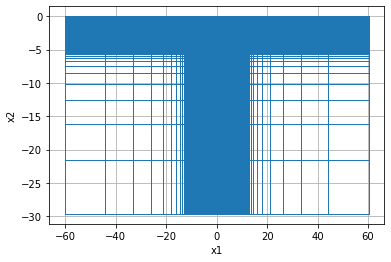

In [2]:
n_elec = 48 # number of electrodes
e_spacing = 0.5 # interelectrode spacing
n_between = 4. # how many cells between each electrode

csx =e_spacing / n_between 
csz = 0.0625

# number of core cells 
ncx = n_elec * e_spacing /csx +1
ncz = 88

# number of padding cells 
npadx = 12
npadz = 12

# create mesh
hx = [(csx, npadx, -1.5), (csx, ncx), (csx, npadx, 1.5)]
hz = [(csz, npadz, -1.5), (csz, ncz)]
mesh = discretize.TensorMesh([hx, hz],x0="CN")

print("number of cells =", mesh.nC)

mesh.plotGrid();

# Create a survey


In [3]:
IO = DC.IO()
xmin, xmax = -11.75,11.75 # survey end points
zmin, zmax = -0.59375,-0.59375 # put electrodes below water layer at a cell centre
endl = np.array([[xmin, zmin], [xmax, zmax]])
survey = DCutils.generate_dcip_survey(endl, "dipole-dipole", dim=mesh.dim, a=0.5, b=0.5, n=10)
survey = IO.from_ambn_locations_to_survey(
    survey.locations_a,
    survey.locations_b,
    survey.locations_m,
    survey.locations_n,
    survey_type='dipole-dipole',
    data_dc_type="volt",
)

/Users/teddiherringnew/anaconda/envs/simpeg14/lib/python3.7/site-packages/SimPEG/electromagnetics/static/resistivity/IODC.py:190: UserWarning: code under construction - API might change in the future
  warnings.warn("code under construction - API might change in the future")


# Create a conductivity model

### Water saturation

In [4]:
# load water content profile
theta = np.load('theta2.npy',encoding = 'latin1')
z_theta = np.load('z_theta2.npy',encoding = 'latin1')

# interpolate onto mesh
theta_mesh = np.interp(mesh.vectorCCy,z_theta,theta)
theta2D = np.repeat(theta_mesh,mesh.nCx)

# saturation model

# background
Sw_bg = 0.2
Sw = ones(mesh.nC) * Sw_bg

# infiltration x location
Ix = np.where(np.logical_and(-2.5 < mesh.gridCC[:,0], mesh.gridCC[:,0]< 2.5))

# infiltration with depth
for i in range(mesh.nCy):
    Iz = (np.where(mesh.gridCC[:,-1]==mesh.vectorCCy[i])) # infiltration x location
    Sw[np.intersect1d(Ix, Iz)] = (theta_mesh[i]*0.4)

# add 0.5 m water layer
z_layer = -0.5
Sw [mesh.gridCC[:, -1] > z_layer] = 2 # 2 is just a placeholder, b/c we'll say Sw>1.0 is just water


### Temperature

In [5]:
# load temperature curve from 1D conductive heat transport model, January profile
z = np.load('z_infiltration.npy',encoding = 'latin1')
T = np.load('T_infiltration.npy',encoding = 'latin1')

# interpolate onto mesh
T_mesh = np.interp(-mesh.vectorCCy,-z,T)
T2D = np.repeat(T_mesh,mesh.nCx)


### Petrophysical relationship (from Herring et al. 2019)

In [6]:
def ref2earth(T,a,por,m,n,Sw0,C0,d,popt=None):
    
    rho_f25 = (0.16*C0)**-1   

    rho_0 = rho_f25 * (d*(0-25)+1)**-1
    
    if Sw0>1:  # shortcut so we can just get resistivity of water layer
        return rho_f25 * (d*(T-25)+1)**-1
    
    else:
        
        if T > 0:
            rho_f = rho_f25 * (d*(T-25)+1)**-1
            R_earth = a * por**-m * Sw0**-n *  rho_f

        else:
            Sw = func_exp(T, *popt)
            Sr = Sw/Sw0
            rho_f = (Sr*(rho_0))
            R_earth = a * por**-m * Sw**-n * rho_f

        return R_earth
    

### Putting it all together...

In [7]:
# fitting parameters from Herring et al. 2019
d = 0.0215
por = 0.40
Sw0 = 1.0
a = 0.363
m = 1.32 
n = 2.29

rho = []
for i in range(mesh.nC):
    rho = np.append(rho,ref2earth(T2D[i],a,por,m,n,Sw[i],1./0.5,d))
    
sig = 1./rho.copy()    

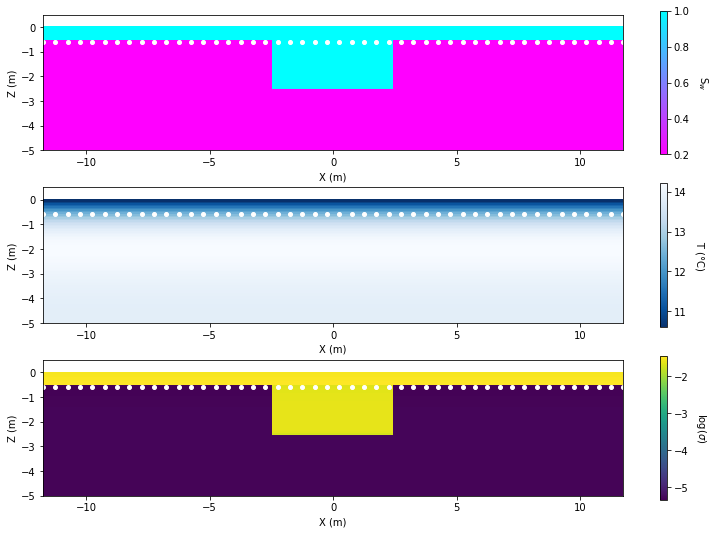

In [8]:
# plot model inputs and output
fig, ax = plt.subplots(3,1, figsize=[13,9])

dat = mesh.plotImage(Sw,ax=ax[0],pcolorOpts={"cmap": "cool_r"},clim=[min(Sw),1])
cbar = colorbar(dat[0],ax=ax[0])
cbar.set_label(r'S$_w$', rotation=270,labelpad=20)

dat = mesh.plotImage(T2D,ax=ax[1],pcolorOpts={"cmap": "Blues_r"})
cbar = colorbar(dat[0],ax=ax[1])
cbar.set_label(r'T ($\degree$C)', rotation=270,labelpad=20)

dat = mesh.plotImage(log(sig),ax=ax[2],pcolorOpts={"cmap": "viridis"})
cbar = colorbar(dat[0],ax=ax[2])
cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20)

for a in ax:
    a.set_ylim([-5,0.5])
    a.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1],'wo',markersize=4)
    a.set_xlabel('X (m)')
    a.set_ylabel('Z (m)')
    a.set_aspect(1)


# Simulate data

In [9]:
# calculate geometric factor for buried electrodes using source images

def get_d(loc1,loc2):
    d = np.sqrt((loc2[0]-loc1[0])**2 + (loc2[1]-loc1[1])**2 )
    return d

A = survey.a_locations.copy()
B = survey.b_locations.copy()
M = survey.m_locations.copy()
N = survey.n_locations.copy()

AP = survey.a_locations.copy()
BP = survey.b_locations.copy()
MP = survey.m_locations.copy()
NP = survey.n_locations.copy()

AP.T[1] = -AP.T[1]
BP.T[1] = -BP.T[1]
MP.T[1] = -MP.T[1]
NP.T[1] = -NP.T[1]

geo_fact = []

for i in range(survey.nD):
    ramP = get_d(AP[i],M[i])
    ranP = get_d(AP[i],N[i])
    rbmP = get_d(BP[i],M[i])
    rbnP = get_d(BP[i],N[i])
    ram = get_d(A[i],M[i])
    ran = get_d(A[i],N[i])
    rbm = get_d(B[i],M[i])
    rbn = get_d(B[i],N[i])    
    
    geo_fact.append((+ 1./ram + 1./ramP
                     - 1./rbm - 1./rbmP 
                     - 1./ran - 1./ranP
                     + 1./rbn + 1./rbnP)
                   /(4. * pi) )
    

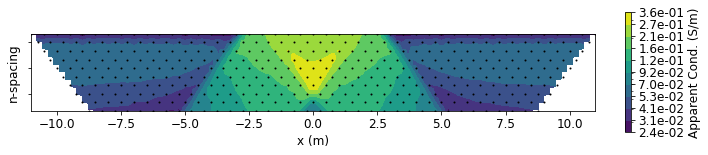

In [10]:
expmap = maps.ExpMap(mesh)
mapping = expmap 
simulation = DC.Simulation2DCellCentered(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver, bc_type="Neumann"
)

# overwrite geometric factor
IO.G = geo_fact

rel_err = 0.01
np.random.seed(1)
data = simulation.make_synthetic_data(log(sig), relative_error=rel_err, add_noise=True)
IO.plotPseudoSection(data=1./(data.dobs/geo_fact), data_type="apparent_conductivity")

# Smooth inversion

In [11]:
from datetime import datetime
np.random.seed(2)

# simulation
sim = DC.Simulation2DCellCentered(
    mesh, survey=survey, sigmaMap=mapping, solver=Solver, bc_type="Neumann",miniaturize=True)

# reference model 
m0 = np.ones(mapping.nP)*np.log(1./mean(data.dobs/IO.G))

# data misfit
dmisfit = data_misfit.L2DataMisfit(simulation=sim, data=data)

# regularization mapping
regmap = maps.IdentityMap(nP=mesh.nC)

# inversion components
reg = regularization.Tikhonov(mesh, mapping=regmap)
reg.alpha_x = 1.
opt = optimization.InexactGaussNewton(maxIter=20)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
invProb.beta = 1.
target = directives.TargetMisfit()
saveIter = directives.SaveOutputEveryIteration()
saveModel = directives.SaveModelEveryIteration()
inv = inversion.BaseInversion(invProb, directiveList=[saveIter,saveModel,target])

# run
start_time = time.time()
dtn_standard = datetime.now().strftime("%Y-%m-%d-%H-%M")
mopt_smooth = inv.run(m0)
dpred = sim.dpred(mopt_smooth)
mpe = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print('Mean percent data error = ',mpe)
print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))


SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2021-07-12-18-59.txt'
SimPEG.SaveModelEveryIteration will save your models as: './###-InversionModel-2021-07-12-18-59.npy'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  2.93e+06  0.00e+00  2.93e+06    2.59e+05      0              
   1  1.00e+00  3.56e+05  5.79e-01  3.56e+05    4.04e+04      0              
   2  1.00e+00  1.21e+05  2.32e+00  1.21e+05    7.62e+03      0   Skip BFGS  
   3  1.00e+00  9.94e+04  4.76e+00  9.94e+04    5.94e+03      0   Skip BFGS  
 

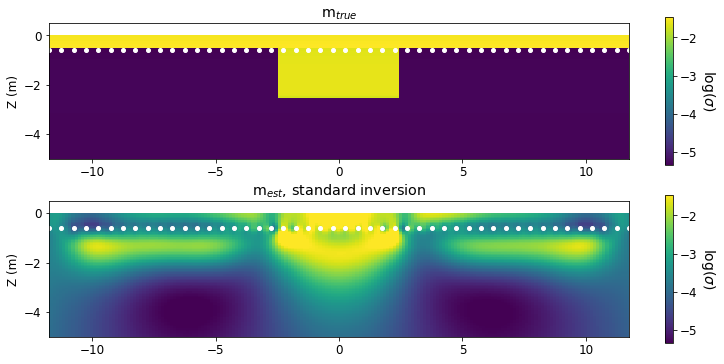

In [12]:
# estimated model 

fig, ax = plt.subplots(2,1, figsize=[13,6])

dat = mesh.plotImage(log(sig),ax=ax[0],clim=[min(log(sig)),max(log(sig))])
ax[0].set_title(r'm$_{true}$')

dat = mesh.plotImage(log(mapping*mopt_smooth),ax=ax[1],clim=[min(log(sig)),max(log(sig))])
ax[1].set_title(r'm$_{est}$, standard inversion')


for a in ax:
    cbar = colorbar(dat[0],ax=a)
    cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20,fontsize=14)
    a.set_aspect(1)
    a.set_ylim([-5,0.5])
    a.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1],'wo',markersize=4)
    a.set_xlabel('')
    a.set_ylabel('Z (m)')     



# Hybrid inversion

### Set up mapping function

In [13]:
import scipy.sparse as sp
from SimPEG.maps import BaseParametric 

class ParametricLayer(BaseParametric):
    """
        Parametric Layer Space

        .. code:: python

            m = [
                val_background,
                layer_z,
                func_coeffs 
            ]

        **Required**

        :param discretize.base.BaseMesh mesh: SimPEG Mesh, 2D or 3D

        **Optional**

        :param float slopeFact: arctan slope factor - divided by the minimum h
                                spacing to give the slope of the arctan
                                functions
        :param float slope: slope of the arctan function
        :param numpy.ndarray indActive: bool vector with

    """

    def __init__(self, mesh, **kwargs):
        super(ParametricLayer, self).__init__(mesh, **kwargs)

    @property
    def nP(self):
        return 4

    @property
    def shape(self):
        if self.indActive is not None:
            return (sum(self.indActive), self.nP)
        return (self.mesh.nC, self.nP)

    def mDict(self, m):
        return {
            "val_background": m[0],
            "layer_z": m[1],
            "func_coeffs": [m[2],m[3]]
        }

    def _atanLayer(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        layer_z = mDict["layer_z"]
        return self._atanfct(z - layer_z, self.slope)

    def f0(self, mDict, z):
        return mDict["func_coeffs"][0] +  mDict["func_coeffs"][1] * z
    
    def _transform(self, m):
        mDict = self.mDict(m)
        
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        
        return (
            self.f0(mDict, z) * self._atanLayer(mDict) + 
            mDict["val_background"] * (1 - self._atanLayer(mDict))
        )
    
    def _deriv_val_background(self, mDict):
        return np.ones_like(self.x) - self._atanLayer(mDict)
    
    def _deriv_layer_z(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        layer_z = mDict["layer_z"]
        return (
            (self.f0(mDict, z) - mDict["val_background"])*
            self._atanfctDeriv(z - layer_z, self.slope)
        )
    
    def _deriv_func_coeffs(self, mDict):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        return(
            np.vstack([
                self._atanLayer(mDict),
                z * self._atanLayer(mDict)
            ])
        )

    def deriv(self, m):
        if self.mesh.dim == 2:
            z = self.y
        elif self.mesh.dim == 3:
            z = self.z
        mDict = self.mDict(m)
        return sp.csr_matrix(
            np.vstack(
                [
                    self._deriv_val_background(mDict),
                    self._deriv_layer_z(mDict),
                    self._deriv_func_coeffs(mDict)
                ]
            ).T
        )


Testing ParametricLayer(21700,4)
==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.217e+01     1.683e-03      nan
 1   1.00e-02    1.217e+00     1.795e-05      1.972
 2   1.00e-03    1.217e-01     1.813e-07      1.996
 3   1.00e-04    1.217e-02     1.814e-09      2.000
========================= PASS! =========================
Once upon a time, a happy little test passed.



(-11.75, 11.75)

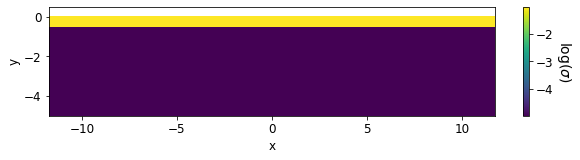

In [14]:
# test
parametric_layer = ParametricLayer(mesh,slopeFact=1e3)
m_background = -5
z_layer = -0.5
m_coeffs = np.r_[-1,0]
m =  np.r_[m_background, z_layer, m_coeffs]

parametric_layer.test(m)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
cbar = plt.colorbar(mesh.plotImage(parametric_layer * m, ax=ax)[0], ax=ax)
cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20,fontsize=14)
ax.set_ylim([-5,0.5])
ax.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])


### Inversion

In [15]:

np.random.seed(0)

rho_min = min(data.dobs/IO.G)
rho_mean = mean(data.dobs/IO.G)
rho_max = max(data.dobs/IO.G)

m_i_hybrid = []
m_i_parametric = []
m_i_smooth = []
phid = []


max_iter = 20

start_time = time.time()

for i in range(0,max_iter):
    
    print(i)
    ### do parametric step
    
    # mapping
    
    # parametric component
    parametric_layer = ParametricLayer(mesh,slopeFact=1e3)
    add_z_layer = maps.InjectActiveCells(mesh, np.r_[True, False, True, False], [z_layer,0], nC=4)
    exp_map_parametric = maps.ExpMap(mesh)
    parametric_map = (exp_map_parametric * parametric_layer * add_z_layer)

    # smooth component
    active_inds = mesh.gridCC[:, -1] < z_layer
    n_active = active_inds.sum()
    active_cells = maps.InjectActiveCells(mesh, active_inds , 0)
    exp_map_smooth = maps.ExpMap(nP=int(n_active))
    smooth_map = active_cells * exp_map_smooth 

    # combine parameteric + smooth
    wires = maps.Wires(("parametric", parametric_map.nP), ("smooth", int(n_active)))
    sum_map = maps.SumMap([parametric_map * wires.parametric, smooth_map * wires.smooth])

    # simulation 
    sim = DC.Simulation2DCellCentered(
        mesh, survey=survey, sigmaMap=sum_map, solver=Solver, bc_type="Neumann")
    
    # reference model
    if i==0:
        m0_parametric = np.r_[np.log(1e-4), np.log(1./rho_min)]
        m0_smooth = np.ones(n_active)*np.log(1./rho_mean)
    else:
        m0_parametric = np.r_[mopt_p[0:2]]
        m0_smooth = mopt_s 
        
    m0 = np.hstack([m0_parametric, m0_smooth])
    
    # data misfit
    dmisfit = data_misfit.L2DataMisfit(simulation=sim, data=data)
    
    # regularization mapping 
    regmap = wires.smooth
    
    # inversion components
    reg = regularization.Tikhonov(mesh, mapping=regmap, indActive=active_inds)
    opt = optimization.InexactGaussNewton(maxIter=1)
    invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
    invProb.beta = 1.
    target = directives.TargetMisfit()
    inv = inversion.BaseInversion(invProb, directiveList=[target])

    # run
    mopt_p = inv.run(m0) 
    m_i_parametric.append(mopt_p)
    m_i_hybrid.append(sum_map*mopt_p)
    phid.append(invProb.phi_d)



    ### do smooth step
    
    # mapping
    active_inds = mesh.gridCC[:, -1] < z_layer
    n_active = active_inds.sum()
    active_cells = maps.InjectActiveCells(mesh, active_inds , exp(mopt_p[1]))
    exp_map_smooth = maps.ExpMap(nP=int(n_active))
    smooth_map = active_cells * exp_map_smooth 

    # simulation 
    sim_smooth = DC.Simulation2DCellCentered(
        mesh, survey=survey, sigmaMap=smooth_map, solver=Solver, bc_type="Neumann"
    )

    # reference model 
    m0_smooth = (mopt_p[2:])
    
    # data misfit
    dmisfit = data_misfit.L2DataMisfit(simulation=sim_smooth, data=data)

    # inversion components
    regmap = maps.IdentityMap(nP=active_cells.nP)
    reg = regularization.Tikhonov(mesh,indActive=active_inds, mapping=regmap)
    opt = optimization.InexactGaussNewton(maxIter=1)
    invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt) 
    invProb.beta = 1.
    target = directives.TargetMisfit()
    inv = inversion.BaseInversion(invProb, directiveList=[target])

    # run
    mopt_s = inv.run(m0_smooth) 
    m_i_smooth.append(mopt_s)
    m_i_hybrid.append(smooth_map * mopt_s)
    phid.append(invProb.phi_d)
    
mopt_hybrid = smooth_map * mopt_s
dpred = sim_smooth.dpred(mopt_s)
mpe = (mean(abs(data.dobs-dpred)/abs(data.dobs))*100)

print('Mean percent data error = ',mpe)
print ('\r Time: {:.0f} mins'.format((time.time() - start_time)/60.))
  

0
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  6.63e+05  0.00e+00  6.63e+05    1.73e+04      0              
   1  1.00e+00  6.52e+05  2.89e-01  6.52e+05    3.70e+05      3              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.0528e+04 <= tolF*(1+|f0|) = 6.6257e+04
0 : |xc-x_last| = 4.8217e+02 <= tolX*(1+|x0|) = 3.9558e+01
0 : |proj(x-g)-x|    = 3.7045e+05 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.7045e+05 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       1    <= iter          =      1
-------------

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  9.48e+03  2.89e+01  9.51e+03    5.13e+04      0              
   1  1.00e+00  8.82e+03  2.89e+01  8.85e+03    4.16e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 6.5730e+02 <= tolF*(1+|f0|) = 9.5079e+02
1 : |xc-x_last| = 2.5416e-02 <= tolX*(1+|x0|) = 8.0489e+01
0 : |proj(x-g)-x|    = 4.1615e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.1615e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       1    <= iter          =      1
---------------

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  2.31e+03  4.16e+01  2.35e+03    4.58e+03      0              
   1  1.00e+00  2.30e+03  4.16e+01  2.35e+03    3.71e+03      2              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.6106e+00 <= tolF*(1+|f0|) = 2.3509e+02
1 : |xc-x_last| = 2.7761e+01 <= tolX*(1+|x0|) = 6.4503e+01
0 : |proj(x-g)-x|    = 3.7141e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 3.7141e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       1    <= iter          =      1
---------------

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.05e+03  4.72e+01  1.10e+03    7.40e+03      0              
   1  1.00e+00  1.05e+03  4.72e+01  1.10e+03    6.88e+03      3              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.3698e+00 <= tolF*(1+|f0|) = 1.1031e+02
1 : |xc-x_last| = 1.7844e+00 <= tolX*(1+|x0|) = 6.5194e+01
0 : |proj(x-g)-x|    = 6.8796e+03 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.8796e+03 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       1    <= iter          =      1
---------------

SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  6.66e+02  4.93e+01  7.15e+02    8.16e+03      0              
   1  1.00e+00  6.49e+02  4.93e+01  6.98e+02    6.97e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 1.6950e+01 <= tolF*(1+|f0|) = 7.1635e+01
1 : |xc-x_last| = 4.1734e-03 <= tolX*(1+|x0|) = 6.6016e+01
0 : |proj(x-g)-x|    = 6.9743e+02 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 6.9743e+02 <= 1e3*eps       = 1.0000e-02
1 : maxIter   =       1    <= iter          =      1
---------------

Mean percent data error =  1.1345126625157504
 Time: 81 mins


### Plot results

Text(0.5, 0, 'X (m)')

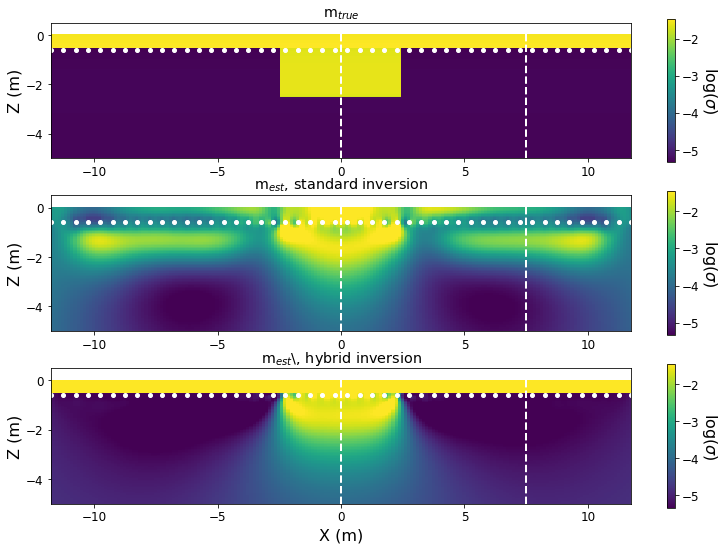

In [16]:
fs = 16
fig, ax = plt.subplots(3,1, figsize=[13,9])

dat = mesh.plotImage(log(sig),ax=ax[0],clim=[min(log(sig)),max(log(sig))])
ax[0].set_title(r'm$_{true}$')

dat = mesh.plotImage(log(mapping*mopt_smooth),ax=ax[1],clim=[min(log(sig)),max(log(sig))])
ax[1].set_title(r'm$_{est}$, standard inversion')

dat = mesh.plotImage(log(mopt_hybrid),ax=ax[2],clim=[min(log(sig)),max(log(sig))])
ax[2].set_title(r'm$_{est}$\, hybrid inversion')

for a in ax:
    cbar = colorbar(dat[0],ax=a)
    cbar.set_label(r'log($\sigma$)', rotation=270,labelpad=20,fontsize=fs)
    a.set_aspect(1)
    a.set_ylim([-5,0.5])
    a.set_xlim([min(survey.electrode_locations.T[0]),max(survey.electrode_locations.T[0])])
    a.plot(survey.electrode_locations.T[0],survey.electrode_locations.T[1],'wo',markersize=4)
    a.set_xlabel('')
    a.set_ylabel('Z (m)',fontsize=fs)   
    a.axvline(x=0,color='w',linestyle='dashed',linewidth=2)
    a.axvline(x=7.5,color='w',linestyle='dashed',linewidth=2)
ax[2].set_xlabel('X (m)', fontsize=fs)


# Compare standard and hybrid inversions

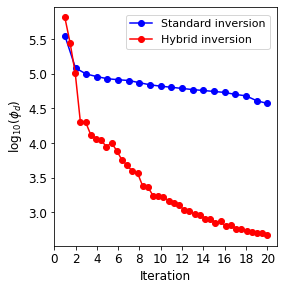

In [17]:
# convergence plots
fig, ax = plt.subplots(1,1, figsize=(4, 4.4))

iters_standard = np.loadtxt('InversionModel-'+dtn_standard+'.txt') # file created with inversion
iters_hybrid = phid.copy()
ax.plot(linspace(1,20,20),log10(np.hstack([iters_standard.T[2]])),'bo-',label='Standard inversion')
ax.plot(linspace(1,20,40),log10(iters_hybrid),'ro-',label='Hybrid inversion')
ax.set_xticks(np.arange(0, 21, step=2));
ax.set_xlabel('Iteration')
ax.set_ylabel(r'log$_{10}$($\phi_d$)')
ax.legend(loc='upper right',bbox_to_anchor=(0.99, 0.99),fontsize=11);


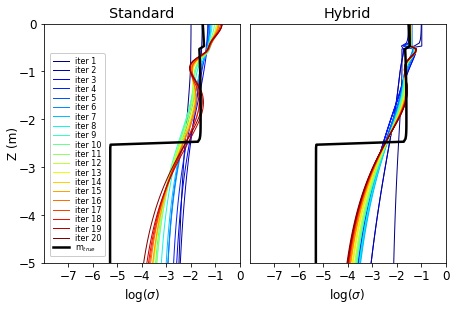

In [18]:
# plot iterations

# standard:

n_iter = len(iters_standard.T[0])

# load model at each iteration
m_i = []
for i in range(1, n_iter+1):
    if i  <10:
        m_i.append(np.load('00%d-InversionModel-'%i+dtn_standard+'.npy'))
    else:
        m_i.append(np.load('0%d-InversionModel-'%i+dtn_standard+'.npy'))
m_i = np.array(m_i)

# plot
colors = plt.cm.jet(np.linspace(0,1,n_iter))
xsl = int(mesh.nCx/2)

fig, ax = plt.subplots(1,2, figsize=[7.2,4.4])

import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(1,2)
gs1.update(wspace=0.05, hspace=0.05) # set the spacing between axes. 
ax[0] = plt.subplot(gs1[0])
ax[1] = plt.subplot(gs1[1])

for i in range(0,n_iter):
    ax[0].plot((np.reshape(log(mapping * m_i[i]),[mesh.nCx,mesh.nCy],order='F'))[xsl],
             (mesh.vectorCCy),'-',color=colors[i],label='iter %.0f'%(i+1),linewidth=1)

# hybrid:

n_iter = len(m_i_hybrid)

# load model at each iteration

# plot
colors = plt.cm.jet(np.linspace(0,1,n_iter))
xsl = int(mesh.nCx/2)

for i in range(0,n_iter):

    ax[1].plot((np.reshape(log(m_i_hybrid[i]),[mesh.nCx,mesh.nCy],order='F'))[xsl],
               (mesh.vectorCCy),'-',color=colors[i],label='iter %.0f'%(i+1),linewidth=1)

for a in ax:
    a.plot(np.reshape(log(sig),[mesh.nCx,mesh.nCy],order='F')[xsl],
             (mesh.vectorCCy),'k-',label=r'm$_{true}$',linewidth=2.5)
    a.set_ylim([-5,0])
    a.set_xlabel(r'log($\sigma$)')
    if a==ax[0]:
        a.set_ylabel("Z (m)",labelpad=-1)
    a.set_xlim([-8,0])
    a.set_xticks(np.arange(-7, 1, step=1));
ax[0].set_title('Standard')
ax[1].set_title('Hybrid')
ax[1].tick_params(axis='y',left=False)
ax[0].legend(loc='lower left',bbox_to_anchor=(0.01, 0.01),
             labelspacing=0.04,fontsize=8,framealpha=1)

frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([]);


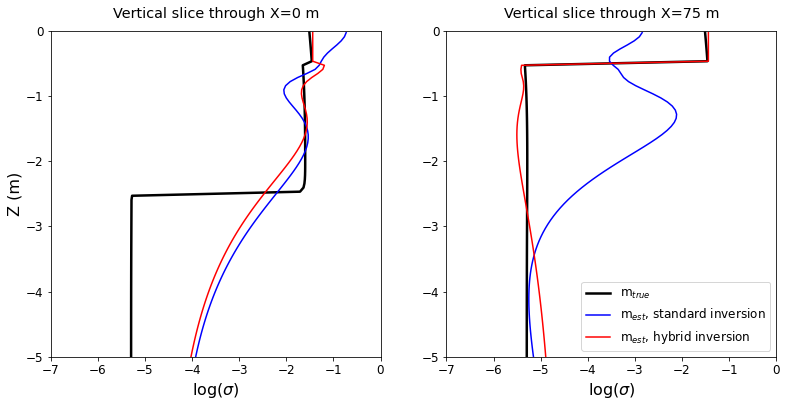

In [19]:
# plot slices

fig, ax = plt.subplots(1,2, figsize=[13,6])

# at x=0m
xsl = int(mesh.nCx/2)
ax[0].plot(np.reshape(log(sig),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'k-',label=r'm$_{true}$',linewidth=2.5)

ax[0].plot(np.reshape(log(exp(mopt_smooth)),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'b',label=r'm$_{est}$, standard inversion',linewidth=1.5)

ax[0].plot(np.reshape(log(mopt_hybrid),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'r-',label=r'm$_{est}$, hybrid inversion',linewidth=1.5)

ax[0].set_title('Vertical slice through X=0 m',y=1.02);    

# at x=7.5m 
xsl = int(mesh.nCx/2)+60
ax[1].plot(np.reshape(log(1./rho),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'k-',label=r'm$_{true}$',linewidth=2.5)

ax[1].plot(np.reshape(log(exp(mopt_smooth)),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'b',label=r'm$_{est}$, standard inversion',linewidth=1.5)

ax[1].plot(np.reshape(log(mopt_hybrid),[mesh.nCx,mesh.nCy],order='F')[xsl],
           (mesh.vectorCCy),'r-',label=r'm$_{est}$, hybrid inversion',linewidth=1.5)

ax[1].set_title('Vertical slice through X=75 m',y=1.02);

for a in ax:
    a.set_ylim([-5,0])
    a.set_xlim([-7,0])
    a.set_xlabel(r'log($\sigma$)',fontsize=fs)
ax[0].set_ylabel('Z (m)',fontsize=fs)
plt.legend();


32.66093527534151


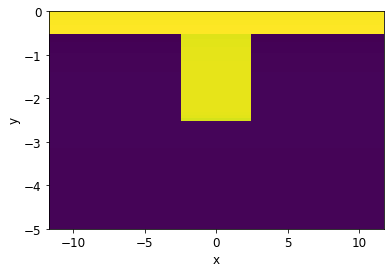

In [21]:
# vectors for mesh
I2 = np.where(mesh.vectorCCx < max(survey.electrode_locations.T[0]))
I3 = np.where(mesh.vectorCCx > min(survey.electrode_locations.T[0]))
I4 = np.intersect1d(I2, I3)
I5 = np.where(mesh.vectorCCy > -5)
I6 = np.intersect1d(I4, I5)

# grid for values
I2b = np.where(mesh.gridCC[:,0] < max(survey.electrode_locations.T[0]))
I3b = np.where(mesh.gridCC[:,0] > min(survey.electrode_locations.T[0]))
I4b = np.intersect1d(I2b, I3b)
I5b = np.where(mesh.gridCC[:,1] > -5)
I6b = np.intersect1d(I4b, I5b)

mesh2 = discretize.TensorMesh([mesh.hx[I4], mesh.hy[I5]],x0="CN")
dat = mesh2.plotImage(log(sig[I6b]),clim=[min(log(sig)),max(log(sig))])

# moptB = np.load('mopt_infiltration_smooth.npy',encoding = 'latin1')
err_smooth = (abs(((mopt_smooth) - log(sig))/log(sig))*100)[I6b]
print(mean(err_smooth))

err_hybrid = (abs((log(mopt_hybrid) - log(sig))/log(sig))*100)[I6b]

In [24]:
mean(err_smooth)

32.66093527534151

In [25]:
mean(err_hybrid)

10.106842616846698